In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas_datareader.data as pdr
from cytoolz import sliding_window
from itertools import groupby

In [ ]:
def test_increasing_value(v):
    if(v>0):
        return 1
    else:
        return 0

def test_decreasing_value(v):
    if(v<0):
        return 1
    else:
        return 0


In [ ]:
def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

In [ ]:
today = datetime.today().strftime('%Y-%m-%d')

past = (datetime.strptime(today, '%Y-%m-%d') - relativedelta(months=21)).strftime('%Y-%m-%d')

In [ ]:
cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [ ]:
bci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [ ]:
cci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [ ]:
np.unique(cci_df.LOCATION)

In [ ]:
bci_df_USA = bci_df[bci_df['LOCATION']=='USA']
bci_df_USA.index = bci_df_USA[bci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cci_df_USA = cci_df[cci_df['LOCATION']=='USA']
cci_df_USA.index = cci_df_USA[cci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cli_df_USA = cli_df[cli_df['LOCATION']=='USA']
cli_df_USA.index = cli_df_USA[cli_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))

In [ ]:
#QTR_SMA = cli_df_USA['Value'].rolling(3).mean()
ST_SMA = cli_df_USA['Value'].rolling(12).mean()
LT_SMA = cli_df_USA['Value'].rolling(12*4).mean()
LT_SMA_MIN = cli_df_USA['Value'].rolling(12*4).min()
LT_SMA_MAX = cli_df_USA['Value'].rolling(12*4).max()

signal_ = ST_SMA - LT_SMA

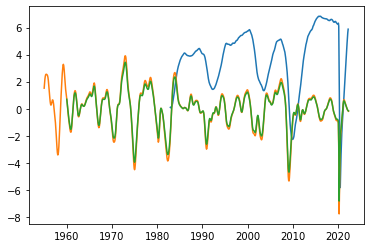

In [118]:
USALOLITONOSTSAM = pdr.DataReader('USALOLITONOSTSAM','fred','1955-01-01',today)-100

USPHCI = pdr.DataReader('USPHCI','fred','1955-01-01',today)
USPHCI_signal = USPHCI.rolling(4).mean()-USPHCI.rolling(12*4).mean()
plt.plot(USPHCI_signal)

"""
signal = USALOLITONOSTSAM['USALOLITONOSTSAM']

Recovery = (signal<0)*(signal.diff(1)>0)
Expansion = (signal>0)*(signal.diff(1)>0)
Slowdown = (signal>0)*(signal.diff(1)<0)
Recession = (signal<0)*(signal.diff(1)<0)
"""
combined_leading = pd.concat([cli_df_USA['Value']-100,USALOLITONOSTSAM],axis=1)

#signal = combined_leading.mean(axis=1)
signal = combined_leading.mean(axis=1).asfreq('d').interpolate().asfreq('q')
plt.plot(combined_leading)
plt.show()

In [ ]:
#cli_range_df = cli_df_USA[(cli_df_USA.index<=today) & (cli_df_USA.index>=past)]

In [119]:
#plt.plot(USPHCI.diff())

In [120]:
troughs = LT_SMA_MIN
#troughs = signal_trough

peaks = LT_SMA_MAX
#peaks = signal_peak

signal_trough = signal.rolling(12*4).min()
signal_peak = signal.rolling(12*4).max()

signal_ST_SMA = signal.rolling(12).mean()
signal_LT_SMA = signal.rolling(12*4).mean()

In [121]:
#Slowdown = (signal_ST_SMA < signal_peak)
#np.sum(Slowdown)

In [122]:
"""
Slowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)
Slowdown = (signal.pct_change()<0) * (signal<signal_peak)# (ST_SMA<LT_SMA)
np.sum(Slowdown)
"""

"\nSlowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)\nSlowdown = (signal.pct_change()<0) * (signal<signal_peak)# (ST_SMA<LT_SMA)\nnp.sum(Slowdown)\n"

In [123]:
#The LEI Index YoY changes are positive and above long-term trends
#Expansion = (cli_df_USA['Value']>LT_SMA) * (ST_SMA.pct_change()>0) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))

#***
#Expansion = (signal>signal_LT_SMA) * (signal_ST_SMA.diff()>0) * (signal>signal.shift(1))

Expansion = (signal>signal_LT_SMA) * np.logical_or(((signal_ST_SMA>signal_LT_SMA).values),((signal_ST_SMA.diff()>0).values))# * (signal>signal.shift(1))
np.sum(Expansion)

#Recovery = (cli_df_USA['Value'] > troughs) * (cli_df_USA['Value']<LT_SMA) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))
Recovery = (signal > signal_trough) * (signal>signal.shift(1)) * (Expansion==0) * (signal<signal_LT_SMA)
np.sum(Recovery)

print(np.sum(Recovery*Expansion))

Declining = ((Recovery!=1)*(Expansion!=1))
print(np.sum(Declining))

###Recession

today_minus_yesterday = signal-signal.shift(1)

yesterday_minus_today = signal.shift(1)-signal

#rapidly declines to a trough

#today is less than yesterday
#at an accelerating pace OR
    #yesterday was receding
#Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values|(today_minus_yesterday.shift(1)<0).values)) # * (signal == signal_trough))
Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values)) * (signal == signal_trough)

print(np.sum(Recession))

#prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]

Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)
print(Slowdown)

#Slowdown = (ST_SMA < peaks)

0
124
3
1955-03-31    False
1955-06-30    False
1955-09-30    False
1955-12-31    False
1956-03-31    False
              ...  
2021-03-31     True
2021-06-30     True
2021-09-30     True
2021-12-31    False
2022-03-31    False
Freq: Q-DEC, Length: 269, dtype: bool


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the b

In [124]:
#plt.plot(prior_recession * Slowdown['USPHCI'])

In [125]:
"""
print(np.sum(Slowdown))

while (np.sum(prior_recession * Slowdown['USPHCI'])>0):
     
    positions = prior_recession * Slowdown['USPHCI']
    
    #print(np.where(positions))
    
    Recession.iloc[positions] = True
    Slowdown.iloc[positions] = False

    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)
    #positions = np.intersect1d(prior_recession,Slowdown)
    #Recession.iloc[positions] = True
    #Slowdown.iloc[positions] = False
    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)
    
    
    
    #print(np.sum(Slowdown))

    
"""

"\nprint(np.sum(Slowdown))\n\nwhile (np.sum(prior_recession * Slowdown['USPHCI'])>0):\n     \n    positions = prior_recession * Slowdown['USPHCI']\n    \n    #print(np.where(positions))\n    \n    Recession.iloc[positions] = True\n    Slowdown.iloc[positions] = False\n\n    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)\n    #positions = np.intersect1d(prior_recession,Slowdown)\n    #Recession.iloc[positions] = True\n    #Slowdown.iloc[positions] = False\n    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)\n    \n    \n    \n    #print(np.sum(Slowdown))\n\n    \n"

In [126]:
"""
list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(list1)]
print(count_dups)
"""

business_cycle = pd.concat([signal,Recovery,Expansion,Slowdown,Recession],axis=1)
business_cycle.columns=['Leading','Recovery','Expansion','Slowdown','Recession']
business_cycle = business_cycle.reindex(signal_peak.dropna().index).dropna()

"""
for c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):
    c = business_cycle.iloc[:,1:].columns[c_-1]
    business_cycle[c][business_cycle[c]==True] = c_
    business_cycle[c][business_cycle[c]==False] = np.nan

repeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]

#list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]
print(count_dups)

"""

'\nfor c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):\n    c = business_cycle.iloc[:,1:].columns[c_-1]\n    business_cycle[c][business_cycle[c]==True] = c_\n    business_cycle[c][business_cycle[c]==False] = np.nan\n\nrepeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]\n\n#list1 = [-1, -1, 1, 1, 1, -1, 1]\ncount_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]\nprint(count_dups)\n\n'

In [127]:
"""
iter = 0
values = []
iterator=0
for c_ in range(0,len(count_dups)):
    c = count_dups[c_]
    #values.append()
    #c_* len(iterator)
    iterator = iterator + c - 1
    values.append(repeats[c_+iterator])
    
values_df = pd.DataFrame(values)

values_df[(values_df==3)*(values_df.shift(1)==4)] = 4
"""

'\niter = 0\nvalues = []\niterator=0\nfor c_ in range(0,len(count_dups)):\n    c = count_dups[c_]\n    #values.append()\n    #c_* len(iterator)\n    iterator = iterator + c - 1\n    values.append(repeats[c_+iterator])\n    \nvalues_df = pd.DataFrame(values)\n\nvalues_df[(values_df==3)*(values_df.shift(1)==4)] = 4\n'

In [128]:
#plt.plot(values_df)

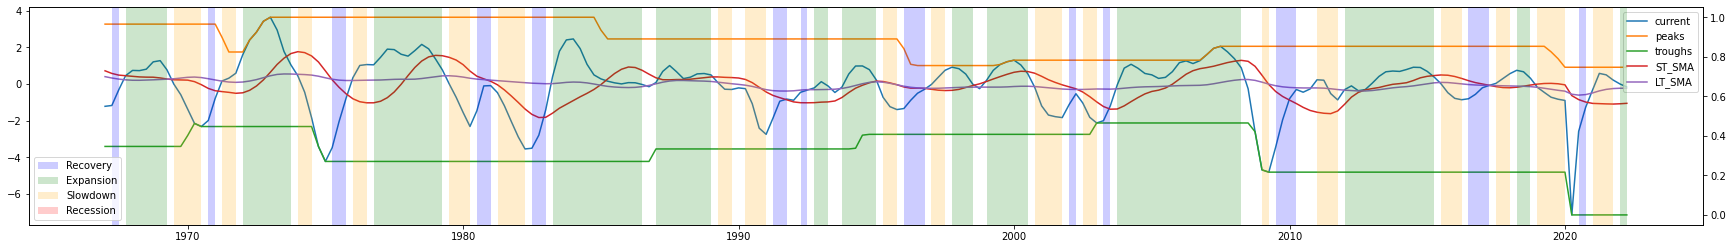

In [141]:


fig, ax1 = plt.subplots( figsize=(30,4) )
#plt.plot(cli_df_USA['Value'])
plt.plot(signal.reindex(business_cycle.index))

plt.plot(signal_peak.reindex(business_cycle.index))
plt.plot(signal_trough.reindex(business_cycle.index))
plt.plot(signal_ST_SMA.reindex(business_cycle.index))
plt.plot(signal_LT_SMA.reindex(business_cycle.index))
plt.legend(['current','peaks','troughs','ST_SMA','LT_SMA'],loc=1)
#plt.legend(['current','ST_SMA','LT_SMA'],loc=1)

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax2.plot(Expansion)

#ax2.legend(['Recovery'],loc=2)

#ax2.plot(Slowdown)
#ax2.plot(Recession)

#ax2.plot(Expansion)

#ax2.legend(['Recovery','Recession','Expansion'],loc=2)
#ax2.legend(['Slowdown','Recession'],loc=2)

#ax3.axhline(y = 0, color = 'r', linestyle = '-')
#ax2.plot(signal)
#If st is less than lt
#ax2.plot((signal>0))

#ax2.plot(signal_peak)
#ax2.plot(signal_trough)
"""
ax2.plot(Recovery)
ax2.plot(Expansion)
ax2.plot(Slowdown)
ax2.plot(Recession)
"""
#ax2.legend(['Recession'],loc=2)

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)

#ax2.axhline(1, color='green', lw=2, alpha=0.5)
#ax2.axhline(1, color='red', lw=2, alpha=0.5)

"""
ax2.fill_between(business_cycle.index, 0, 1, where=Recovery['USPHCI'].reindex(business_cycle.index) == 1,facecolor='blue', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Expansion['USPHCI'].reindex(business_cycle.index) == 1,facecolor='orange', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Slowdown['USPHCI'].reindex(business_cycle.index) == 1,facecolor='green', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Recession['USPHCI'].reindex(business_cycle.index) == 1,facecolor='red', alpha=0.5, transform=trans)
"""   
    
ax2.fill_between(business_cycle.index, 0, 1, where=Recovery.reindex(business_cycle.index) == 1,facecolor='blue', alpha=0.2, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Expansion.reindex(business_cycle.index) == 1,facecolor='green', alpha=0.2, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Slowdown.reindex(business_cycle.index) == 1,facecolor='orange', alpha=0.2, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Recession.reindex(business_cycle.index) == 1,facecolor='red', alpha=0.2, transform=trans)

ax2.legend(['Recovery','Expansion','Slowdown','Recession'],loc=3)

plt.savefig("output.jpg")

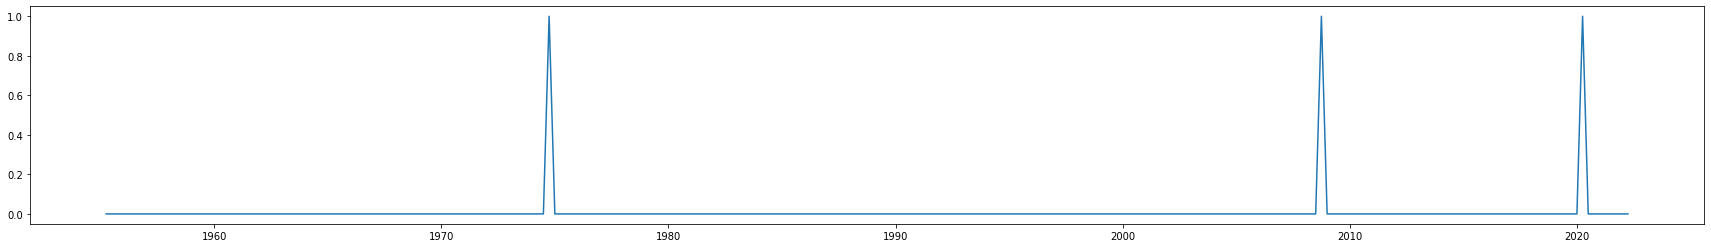

In [130]:
fig, ax1 = plt.subplots( figsize=(30,4) )
plt.plot(Recession)
#plt.legend(loc=1)
#plt.legend(loc=3)
plt.show()

In [139]:
business_cycle.style.applymap(highlight_cells)

,Leading,Recovery,Expansion,Slowdown,Recession
1966-12-31 00:00:00,-1.217042,False,False,True,False
1967-03-31 00:00:00,-1.172331,True,False,False,False
1967-06-30 00:00:00,-0.323553,True,False,False,False
1967-09-30 00:00:00,0.461002,False,True,False,False
1967-12-31 00:00:00,0.745463,False,True,False,False
1968-03-31 00:00:00,0.734483,False,True,False,False
1968-06-30 00:00:00,0.813323,False,True,False,False
1968-09-30 00:00:00,1.213959,False,True,False,False
1968-12-31 00:00:00,1.279817,False,True,False,False
1969-03-31 00:00:00,0.778264,False,True,False,False


In [136]:
business_cycle.iloc[:,1:].sum(axis=1).max()

1

In [137]:
business_cycle.iloc[:,1:].sum(axis=0)

Recovery      38
Expansion    107
Slowdown      74
Recession      3
dtype: int64

In [134]:
#today_minus_yesterday.map(lambda t: test_decreasing_value(t))

In [138]:
np.sum(business_cycle.iloc[:,1:].sum(axis=0))

222